In [2]:
!pip install kaggle




[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from google.colab import files
files.upload()   # upload kaggle.json


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d dataset


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  plantdisease.zip
replace dataset/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_dir = "/content/plant_disease/PlantVillage"


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
train_dir = "/content/dataset/PlantVillage"


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 80% train, 20% validation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1
)


517/517 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.3395 - loss: 2.0888 - val_accuracy: 0.6931 - val_loss: 0.9316


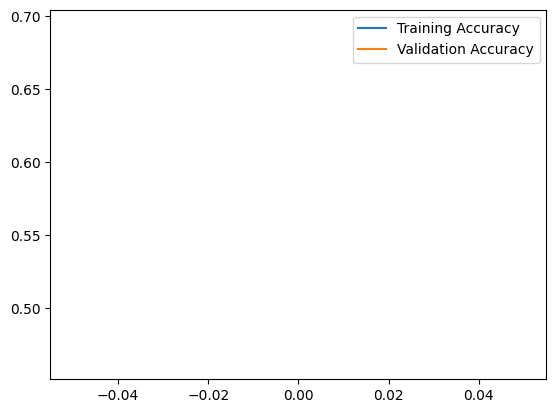

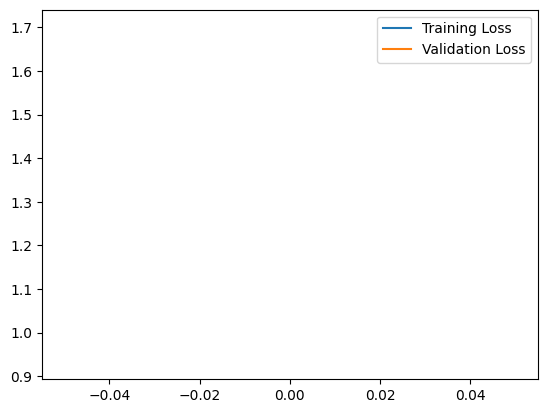

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/dataset/PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
class_idx = np.argmax(prediction)
print("Predicted Class:", list(train_generator.class_indices.keys())[class_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Predicted Class: Tomato_Septoria_leaf_spot


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image

# ==========================
# Disease Treatment Dictionary
# ==========================
treatment_dict = {
   "Tomato_Bacterial_spot":"*Spray copper-based bactericides, avoid overhead watering, and use resistant tomato varieties.* Use Streptomycin sulfate(100-200 ppm) in early stages for bacterial control.* Apply Bacillus subtilis-based biocontrol sprays (organic option).* Disinfect seeds in hot water (50°C for 25 min) before sowing.* Avoid handling plants when leaves are wet.",
    "Tomato_Early_blight": "*Use fungicides like Mancozeb or Chlorothalonil. Remove infected leaves.*Alternate sprays with Azoxystrobin or Difenoconazole for resistance management.*Apply Neem oil (3%) weekly as an organic preventive.*Maintain crop rotation with non-solanaceous crops (avoid potato/tomato repeatedly).*Improve field aeration and reduce humidity.",
    "Tomato_Late_blight": "*Apply fungicides (Metalaxyl, Copper-based). Destroy infected plants.*Preventively spray Cymoxanil + Mancozeb mixture every 7–10 days.*Use Ridomil Gold (systemic + contact fungicide) before rainfall.*Avoid overhead irrigation, and ensure proper drainage.*Burn or deeply bury infected debris.",
    "Tomato__Tomato_mosaic_virus":"There’s no direct chemical cure for viruses, but you can suppress spread*Disinfect tools and hands with 10% bleach (sodium hypochlorite) or 5% milk solution.*Use virus-free certified seeds only.*Spray seaweed extract or micronutrient formulations to boost plant immunity.*Apply Neem oil (3%) to repel secondary pests (like aphids) that may aid spread.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus":"*Spray Imidacloprid (0.3 ml/L) or Thiamethoxam (0.25 g/L) to control whiteflies.*Alternate with Spiromesifen or Buprofezin to prevent resistance.*Use Neem oil (3%) or Azadirachtin (1500 ppm) every 7 days for eco-friendly pest control.*Apply seaweed or micronutrient foliar sprays to reduce stress and improve recovery.",
    "Tomato_Septoria_leaf_spot":"*Spray Mancozeb (0.25%) or Chlorothalonil (2 g/L) at the first sign of spotting.*Alternate with Copper oxychloride or Azoxystrobin every 10–14 days.*For severe cases: use Difenoconazole (Score 250 EC – 0.1%) to stop further fungal spread.*Apply Trichoderma harzianum as a soil drench to suppress fungal inoculum.*Avoid repeated use of the same fungicide (rotate chemical groups).",
    "Tomato_Spider_mites_Two_spotted_spider_mite":"*Spray Neem oil (3%) or Karanj oil on leaf undersides.*Release predatory mites (Phytoseiulus persimilis or Neoseiulus californicus) to naturally control TSSM.*Garlic-chili or insecticidal soap sprays to reduce mite population.",
    "Pepper__bell___Bacterial_spot": "*Apply copper bactericides. Avoid water splash. Use resistant seeds.*Seed treatment with 1% sodium hypochlorite for 1 minute.*Use Kasugamycin spray for bacterial suppression.*Incorporate compost tea or Trichoderma to improve soil health.*Avoid working in fields when plants are wet.",
    "Potato___Early_blight": "*Spray fungicide with Azoxystrobin. Remove diseased foliage.*Use Mancozeb + Carbendazim alternately every 10 days.*Apply Neem seed kernel extract (5%) as an eco-friendly spray.*Maintain balanced nitrogen and potassium levels (excess nitrogen favors blight).*Destroy volunteer potato plants between seasons.",
    "Potato___Late_blight": "*Use Copper fungicides. Ensure good drainage.*Preventive use of Chlorothalonil or Cymoxanil.*Start spraying before rainfall and repeat every 7 days.*Grow resistant cultivars like Kufri Jyoti or Kufri Bahar.*Ensure early planting to escape peak disease period.",
    "Tomato__Target_Spot": "*Apply fungicides (Myclobutanil). Remove mummified fruit.*Alternate sprays with Chlorothalonil or Azoxystrobin.*Apply biocontrol agent Trichoderma harzianum to suppress soilborne inoculum.*Avoid excess nitrogen fertilizer and dense planting.*Practice 2–3 year crop rotation.",
    "Tomato_healthy": "Disease-free zone! 🌞 Ensure proper sunlight and airflow for continued health.!👌 Keep up good farm hygiene.",
    "Pepper__bell___healthy": "Healthy and thriving! 🌱 Maintain proper watering and nutrient schedule."
}

# Global memory to store last prediction
last_prediction = {"disease": None, "treatment": None}

# ==========================
# Prediction Function
# ==========================
def predict_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_name = list(train_generator.class_indices.keys())[class_idx]

    # Get treatment
    treatment = treatment_dict.get(class_name, "No treatment info available.")

    # Store last prediction
    last_prediction["disease"] = class_name
    last_prediction["treatment"] = treatment

    return {class_name: float(pred[0][class_idx])}, f"💡 Suggested Treatment: {treatment}"


# ==========================
# Chatbot Function
# ==========================
def chatbot_response(history, user_input):
    if last_prediction["disease"] is None:
        bot_reply = "🌱 Please upload a crop leaf image first."
    else:
        disease = last_prediction["disease"]
        treatment = last_prediction["treatment"]

        if "treatment" in user_input.lower():
            bot_reply = f"💊 Treatment for {disease}: {treatment}"
        elif "disease" in user_input.lower():
            bot_reply = f"🦠 The detected disease is: {disease}"
        elif "prevent" in user_input.lower():
            bot_reply = f"🛡️ Prevention tips for {disease}: Regular monitoring, crop rotation, resistant seeds, and timely fungicide use."
        else:
            bot_reply = f"I only know about the last detected disease ({disease}). You can ask me about 'treatment', 'disease name', or 'prevention'."

    history.append((user_input, bot_reply))
    return history, ""


#treatment#

print(list(train_generator.class_indices.keys()))

treatment_dict = {
   "Tomato_Bacterial_spot":"*Spray copper-based bactericides, avoid overhead watering, and use resistant tomato varieties.* Use Streptomycin sulfate(100-200 ppm) in early stages for bacterial control.* Apply Bacillus subtilis-based biocontrol sprays (organic option).* Disinfect seeds in hot water (50°C for 25 min) before sowing.* Avoid handling plants when leaves are wet.",
    "Tomato_Early_blight": "*Use fungicides like Mancozeb or Chlorothalonil. Remove infected leaves.*Alternate sprays with Azoxystrobin or Difenoconazole for resistance management.*Apply Neem oil (3%) weekly as an organic preventive.*Maintain crop rotation with non-solanaceous crops (avoid potato/tomato repeatedly).*Improve field aeration and reduce humidity.",
    "Tomato_Late_blight": "*Apply fungicides (Metalaxyl, Copper-based). Destroy infected plants.*Preventively spray Cymoxanil + Mancozeb mixture every 7–10 days.*Use Ridomil Gold (systemic + contact fungicide) before rainfall.*Avoid overhead irrigation, and ensure proper drainage.*Burn or deeply bury infected debris.",
    "Tomato__Tomato_mosaic_virus":"There’s no direct chemical cure for viruses, but you can suppress spread*Disinfect tools and hands with 10% bleach (sodium hypochlorite) or 5% milk solution.*Use virus-free certified seeds only.*Spray seaweed extract or micronutrient formulations to boost plant immunity.*Apply Neem oil (3%) to repel secondary pests (like aphids) that may aid spread.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus":"*Spray Imidacloprid (0.3 ml/L) or Thiamethoxam (0.25 g/L) to control whiteflies.*Alternate with Spiromesifen or Buprofezin to prevent resistance.*Use Neem oil (3%) or Azadirachtin (1500 ppm) every 7 days for eco-friendly pest control.*Apply seaweed or micronutrient foliar sprays to reduce stress and improve recovery.",
    "Tomato_Septoria_leaf_spot":"*Spray Mancozeb (0.25%) or Chlorothalonil (2 g/L) at the first sign of spotting.*Alternate with Copper oxychloride or Azoxystrobin every 10–14 days.*For severe cases: use Difenoconazole (Score 250 EC – 0.1%) to stop further fungal spread.*Apply Trichoderma harzianum as a soil drench to suppress fungal inoculum.*Avoid repeated use of the same fungicide (rotate chemical groups).",
    "Tomato_Spider_mites_Two_spotted_spider_mite":"*Spray Neem oil (3%) or Karanj oil on leaf undersides.*Release predatory mites (Phytoseiulus persimilis or Neoseiulus californicus) to naturally control TSSM.*Garlic-chili or insecticidal soap sprays to reduce mite population.",
    "Pepper__bell___Bacterial_spot": "*Apply copper bactericides. Avoid water splash. Use resistant seeds.*Seed treatment with 1% sodium hypochlorite for 1 minute.*Use Kasugamycin spray for bacterial suppression.*Incorporate compost tea or Trichoderma to improve soil health.*Avoid working in fields when plants are wet.",
    "Potato___Early_blight": "*Spray fungicide with Azoxystrobin. Remove diseased foliage.*Use Mancozeb + Carbendazim alternately every 10 days.*Apply Neem seed kernel extract (5%) as an eco-friendly spray.*Maintain balanced nitrogen and potassium levels (excess nitrogen favors blight).*Destroy volunteer potato plants between seasons.",
    "Potato___Late_blight": "*Use Copper fungicides. Ensure good drainage.*Preventive use of Chlorothalonil or Cymoxanil.*Start spraying before rainfall and repeat every 7 days.*Grow resistant cultivars like Kufri Jyoti or Kufri Bahar.*Ensure early planting to escape peak disease period.",
    "Tomato__Target_Spot": "*Apply fungicides (Myclobutanil). Remove mummified fruit.*Alternate sprays with Chlorothalonil or Azoxystrobin.*Apply biocontrol agent Trichoderma harzianum to suppress soilborne inoculum.*Avoid excess nitrogen fertilizer and dense planting.*Practice 2–3 year crop rotation.",
    "Tomato_healthy": "Disease-free zone! 🌞 Ensure proper sunlight and airflow for continued health.!👌 Keep up good farm hygiene.",
    "Pepper__bell___healthy": "Healthy and thriving! 🌱 Maintain proper watering and nutrient schedule."
}


# ==========================
# Gradio Interface
# ==========================
import gradio as gr

with gr.Blocks(theme=gr.themes.Base(), css=".gradio-container {background-color: #f0fdf4;}") as demo:
    # Navigation Bar
    with gr.Row():
        gr.Markdown("""
        <div style="display: flex; justify-content: space-between; align-items: center; padding: 10px 20px; background-color: #2e7d32; color: white;">
            <div style="font-size: 24px; font-weight: bold;">🌱 CropCare AI</div>
            <div>
                <a href="#" style="margin: 0 15px; color: white; text-decoration: none;">Home</a>
                <a href="#" style="margin: 0 15px; color: white; text-decoration: none;">About</a>
                <a href="#" style="margin: 0 15px; color: white; text-decoration: none;">Programs</a>
                <a href="#" style="margin: 0 15px; color: white; text-decoration: none;">Contact</a>
            </div>
        </div>
        """)

    # Hero Section
    gr.Markdown("""
  <div style="
    background-image: url('https://img.freepik.com/premium-photo/hologram-crop-disease-detection-system_1298745-6511.jpg');
    background-size: cover;
    background-position: center;
    height: 400px;
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    color: white;
    text-align: center;
">

    """)

    # Main Detection Section
    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="📷 Upload Crop Leaf")
            disease_label = gr.Label(num_top_classes=1, label="🧬 Predicted Disease")
            treatment_box = gr.Textbox(label="💊 Treatment Suggestion", lines=5)

        with gr.Column(scale=1):
            chatbot = gr.Chatbot(label="🗣️ Agri Assistant Bot")
            msg = gr.Textbox(label="Ask me anything about your crop disease")
            msg.submit(chatbot_response, [chatbot, msg], [chatbot, msg])

    image_input.upload(predict_image, image_input, [disease_label, treatment_box])

    # Footer
    gr.Markdown("""
    <div style="text-align: center; padding: 20px; background-color: #e8f5e9; color: #2e7d32;">
        <p>© 2025 CropCare AI | Designed by Bharath</p>
    </div>
    """)

demo.launch()



['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


/tmp/ipython-input-3976466763.py:138: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="🗣️ Agri Assistant Bot")


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c3ee9adbd95c3fd9a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
